### Elevation Profile Plot from a GPS Track

We will take a GPS track recorded from a [Strava app](https://www.strava.com/mobile) and create an elevation profile plot.

#### Setup and Data Download

The following blocks of code will install the required packages and download the datasets.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !apt install libspatialindex-dev
  !pip install fiona shapely pyproj rtree mapclassify
  !pip install geopandas

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import pandas as pd

In [2]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [3]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [4]:
filename = 'summit.gpx' # # GPX files contain many layers
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/raw/main/data/gps/'

download(data_url + filename)

#### Data Pre-Processing

Our `summit.gpx` file is in [GPS Exchange format](https://en.wikipedia.org/wiki/GPS_Exchange_Format). Location data (and optionally elevation, time, and other information) is stored in tags and can be interchanged between GPS devices and software.

In [5]:
gpx_path = os.path.join(data_folder, filename)
# GPX files contain many layers. Read the 'track_points' layer
gdf = gpd.read_file(gpx_path, layer='track_points')
gdf = gdf[['track_fid','ele', 'time', 'geometry']]
gdf

,track_fid,ele,time,geometry
0,0,3187.3,2022-04-04 00:07:42+00:00,POINT (78.56758 30.82669)
1,0,3194.4,2022-04-04 00:07:54+00:00,POINT (78.56747 30.82667)
2,0,3196.6,2022-04-04 00:07:59+00:00,POINT (78.56743 30.82670)
3,0,3196.8,2022-04-04 00:08:04+00:00,POINT (78.56741 30.82671)
4,0,3198.2,2022-04-04 00:08:14+00:00,POINT (78.56739 30.82668)
...,...,...,...,...
2305,0,3150.8,2022-04-04 06:05:58+00:00,POINT (78.56878 30.82703)
2306,0,3150.5,2022-04-04 06:06:01+00:00,POINT (78.56879 30.82704)
2307,0,3150.3,2022-04-04 06:06:06+00:00,POINT (78.56883 30.82707)
2308,0,3150.3,2022-04-04 06:06:11+00:00,POINT (78.56878 30.82710)


Let's use the timestamp contained in the 'time' column as the index. This will allow us to filter and plot the time-series data easily. We must first convert the time column to datetime type with an appropriate timezone.

In [6]:
gdf['time'] = pd.to_datetime(gdf['time'])
gdf = gdf.set_index('time')
gdf.index = gdf.index.tz_convert('Asia/Kolkata') # specify timezone
gdf

,track_fid,ele,geometry
time,,,
2022-04-04 05:37:42+05:30,0,3187.3,POINT (78.56758 30.82669)
2022-04-04 05:37:54+05:30,0,3194.4,POINT (78.56747 30.82667)
2022-04-04 05:37:59+05:30,0,3196.6,POINT (78.56743 30.82670)
2022-04-04 05:38:04+05:30,0,3196.8,POINT (78.56741 30.82671)
2022-04-04 05:38:14+05:30,0,3198.2,POINT (78.56739 30.82668)
...,...,...,...
2022-04-04 11:35:58+05:30,0,3150.8,POINT (78.56878 30.82703)
2022-04-04 11:36:01+05:30,0,3150.5,POINT (78.56879 30.82704)
2022-04-04 11:36:06+05:30,0,3150.3,POINT (78.56883 30.82707)


Using time as index allows us to filter the data as follows :

In [7]:
gdf_subset = gdf['2022-04-04T06:15:00':'2022-04-04T10:45:00']
gdf_subset

,track_fid,ele,geometry
time,,,
2022-04-04 06:15:00+05:30,0,3337.9,POINT (78.56699 30.83384)
2022-04-04 06:15:05+05:30,0,3338.4,POINT (78.56699 30.83387)
2022-04-04 06:15:11+05:30,0,3338.9,POINT (78.56699 30.83391)
2022-04-04 06:15:16+05:30,0,3339.4,POINT (78.56698 30.83394)
2022-04-04 06:15:21+05:30,0,3340.0,POINT (78.56699 30.83398)
...,...,...,...
2022-04-04 10:42:36+05:30,0,3339.5,POINT (78.56718 30.83418)
2022-04-04 10:42:41+05:30,0,3338.9,POINT (78.56720 30.83417)
2022-04-04 10:43:29+05:30,0,3338.9,POINT (78.56725 30.83422)


We can now plot the elevation against the timestamp using Matplotlib. Since we have a large number of timestamps, we can use `set_major_locator()` to define what labels will be present on the axis.

Since our timestamps are timezone aware, we can also plot a timezone name (i.e. IST) along with the label.

We can also use a different style for our plot. You can run `plt.style.available` to see all available styles.

In [12]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [8]:
plt.style.use('ggplot')

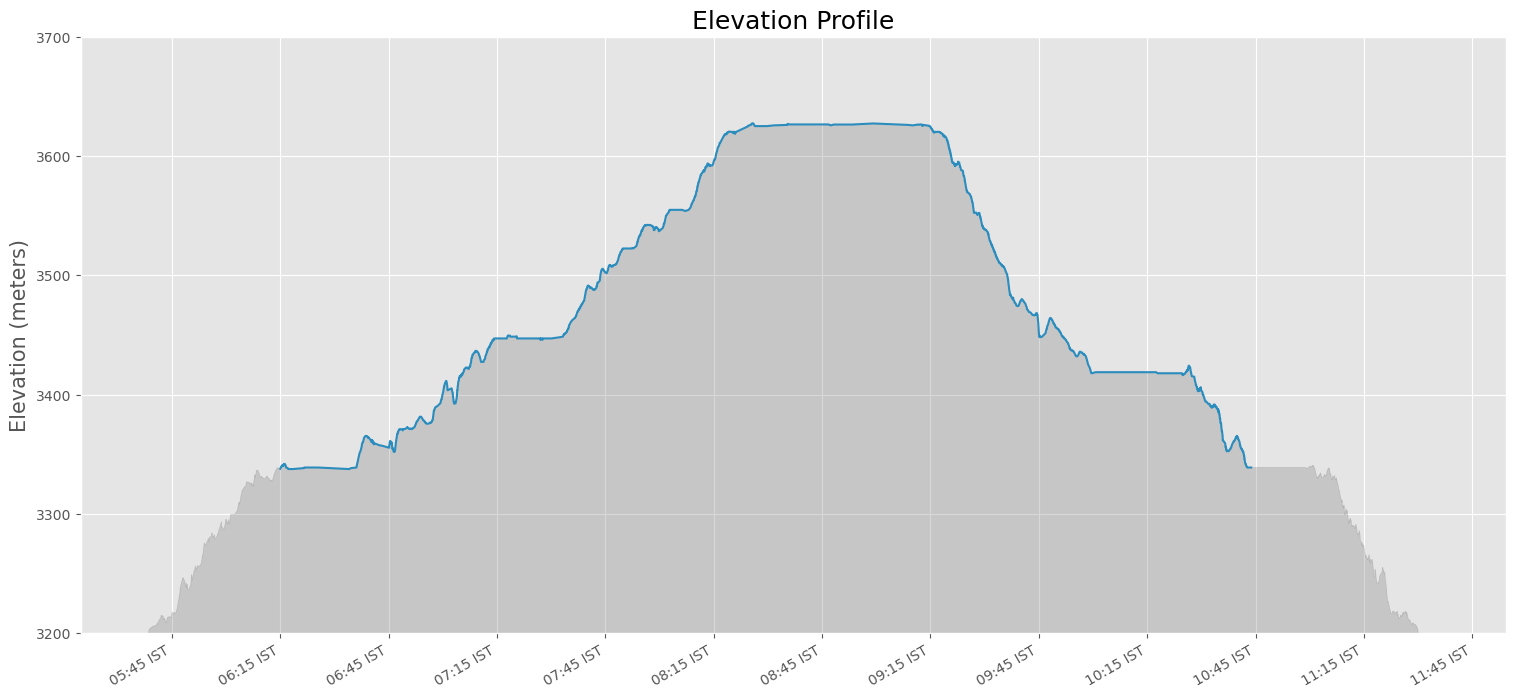

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
gdf_subset['ele'].plot(kind='line', ax=ax, color='#2b8cbe')
plt.tight_layout()
plt.title('Elevation Profile', fontsize = 18)
plt.ylabel('Elevation (meters)', size = 15)
plt.xlabel(None)
# Show a tick every 30 minute
xlocator = mdates.MinuteLocator(interval=30)

xformat = mdates.DateFormatter('%H:%M %Z', tz=gdf.index.tz)  # adds some extra formatting, but not required

ax.xaxis.set_major_locator(xlocator)
ax.xaxis.set_major_formatter(xformat)
ax.set_ylim([3200, 3700])
ax.fill_between(gdf.index, gdf['ele'].values, color='grey', alpha=0.3)
plt.show()

In [13]:
plt.style.use('seaborn-v0_8-pastel')

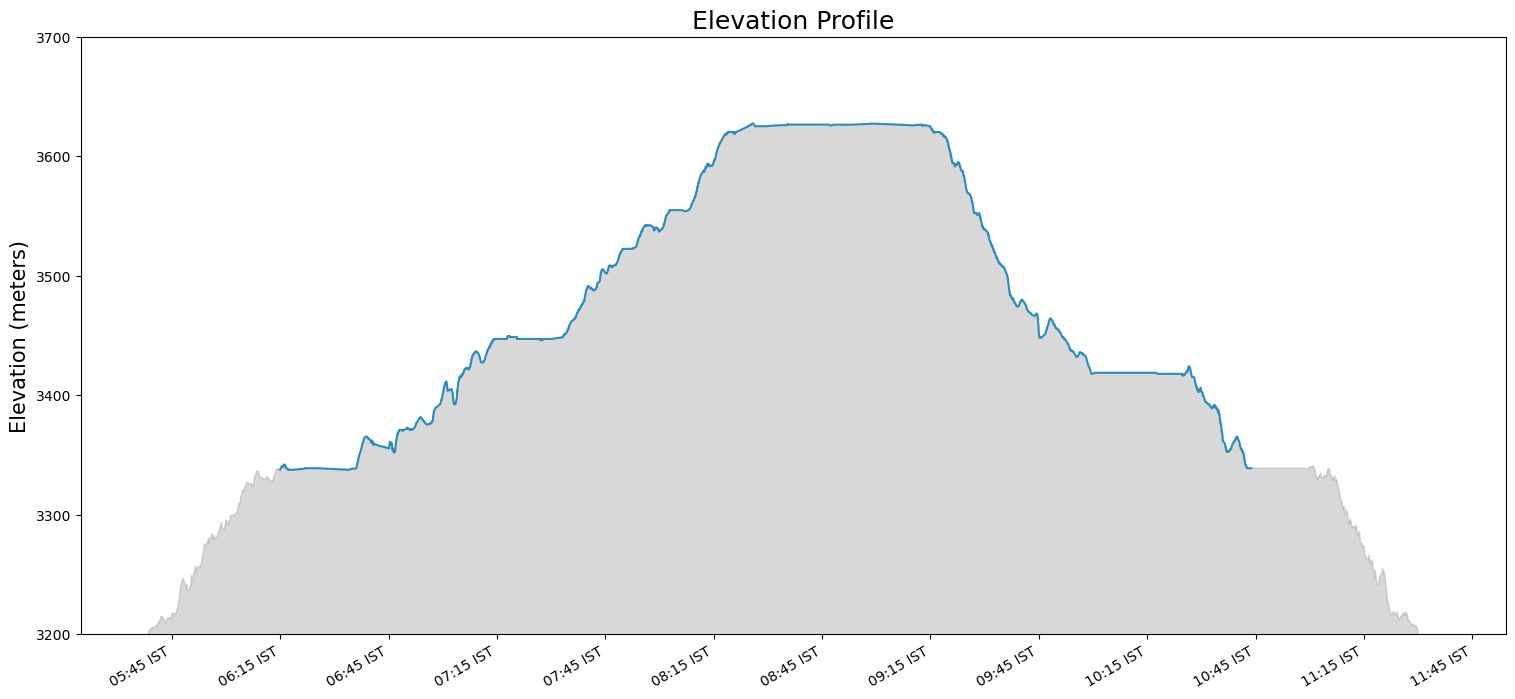

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
gdf_subset['ele'].plot(kind='line', ax=ax, color='#2b8cbe')
plt.tight_layout()
plt.title('Elevation Profile', fontsize = 18)
plt.ylabel('Elevation (meters)', size = 15)
plt.xlabel(None)
# Show a tick every 30 minute
xlocator = mdates.MinuteLocator(interval=30)

xformat = mdates.DateFormatter('%H:%M %Z', tz=gdf.index.tz)  # adds some extra formatting, but not required

ax.xaxis.set_major_locator(xlocator)
ax.xaxis.set_major_formatter(xformat)
ax.set_ylim([3200, 3700])
ax.fill_between(gdf.index, gdf['ele'].values, color='grey', alpha=0.3)
plt.show()